# DC2 Image Analysis, Crab, Upsampling

updated on 2023-11-22 (the commit 84f2e561e9c7c9244f31a6ec30a048559f69c809)

This notebook explains image reconstruction when the pixel resolution of the model map is set higher than the response matrix.

Note that this notebook is advanced. It is assumed that you have already performed the two notebooks (Crab-DC2-ScAtt-DataReduction.ipynb, Crab-DC2-ScAtt-ImageDeconvolution.ipynb).

## Point

In the current implementation, the pixel size of the model map can be differnt from the that of the response. The model pixel size is used in the following instances:

- coordsys_conv_matrix
- image_deconvolution

Thus, make sure that NSIDE in these instances must be the same. In this notebook, I present the case with NSIDE = 16 in the model map.

If the NSIDE for the exposure table is not changed, you do not have to create the binned data.

There are three different NSIDE in priciple:

- NSIDE for the pixel resolution of the model (coordsys_conv_matrix, image_deconvolution)
- NSIDE for the pixel resolution of the response (full_detector_response)
- NSIDE for the pixel resolution of the spacecraftattitude binning (exposure_table)

Usually, these three values can be set equal.

In [52]:
from histpy import Histogram, HealpixAxis, Axis, Axes
from mhealpy import HealpixMap
from astropy.coordinates import SkyCoord, cartesian_to_spherical, Galactic

from cosipy.response import FullDetectorResponse
from cosipy.spacecraftfile import SpacecraftFile
from cosipy.ts_map.TSMap import TSMap
from cosipy.data_io import UnBinnedData, BinnedData
from cosipy.image_deconvolution import SpacecraftAttitudeExposureTable, CoordsysConversionMatrix, DataLoader, ImageDeconvolution

# cosipy uses astropy units
import astropy.units as u
from astropy.units import Quantity
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy.table import Table
from astropy.io import fits
from scoords import Attitude, SpacecraftFrame

#3ML is needed for spectral modeling
from threeML import *
from astromodels import Band

#Other standard libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec 

import healpy as hp
from tqdm.autonotebook import tqdm

In [1]:
nside_scatt_binning = 8
nside_model = 16

In this notebook I assume that the NSIDE for the exposure table is the same as in Crab-DC2-ScAtt-DataReduction.ipynb. So the binned data will be reused.

# 0. Prepare the data
Before running the cells, please download the files needed for this notebook. You can get them from wasabi. 

Actually, the data reduction is not optimized and takes hours depending on your environments. So I skip this process.
Please download the following data files and then run the following cells.

From wasabi
- cosi-pipeline-internal/COSI-SMEX/DC2/Responses/SMEXv12.Continuum.HEALPixO3_10bins_log_flat.binnedimaging.imagingresponse.nonsparse_nside8.area.h5
- cosi-pipeline-public/COSI-SMEX/DC2/Data/Orientation/20280301_3_month.ori

From docs/tutorials/image_deconvolution/Crab
- inputs_Crab_DC2.yaml
- crab_spec.dat

As outputs from the notebook Crab-DC2-ScAtt-DataReduction.ipynb
- Crab_scatt_binning_DC2_bkg.hdf5
- Crab_scatt_binning_DC2_event.hdf5

You can download the data and detector response from wasabi. You can skip this cell if you already have downloaded the files.
Note that the response is not public yet (2023-11-21).

In [ ]:
import os

header = "AWS_ACCESS_KEY_ID=GBAL6XATQZNRV3GFH9Y4 AWS_SECRET_ACCESS_KEY=GToOczY5hGX3sketNO2fUwiq4DJoewzIgvTCHoOv aws s3api get-object"

os.system(header + " --bucket cosi-pipeline-public --key COSI-SMEX/DC2/Data/Sources/crab_3months_unbinned_data.fits.gz --endpoint-url=https://s3.us-west-1.wasabisys.com crab_3months_unbinned_data.fits.gz")

os.system(header + " --bucket cosi-pipeline-public --key COSI-SMEX/DC2/Data/Backgrounds/albedo_photons_3months_unbinned_data.fits.gz --endpoint-url=https://s3.us-west-1.wasabisys.com albedo_photons_3months_unbinned_data.fits.gz")

os.system(header + " --bucket cosi-pipeline-public --key COSI-SMEX/DC2/Data/Orientation/20280301_3_month.ori --endpoint-url=https://s3.us-west-1.wasabisys.com 20280301_3_month.ori")

## Load the response and orientation files

<span style="color:red"> please modify "path_data" corresponding to your environment.</span>

In [3]:
path_data = "path/to/data/"

In [4]:
%%time

ori_filepath = path_data + "orientation/20280301_3_month.ori"
ori = SpacecraftFile.parse_from_file(ori_filepath)

CPU times: user 15.9 s, sys: 1.08 s, total: 17 s
Wall time: 16.6 s


In [7]:
full_detector_response_filename = path_data + "response/SMEXv12.Continuum.HEALPixO3_10bins_log_flat.binnedimaging.imagingresponse.nonsparse_nside8.area.h5"
full_detector_response = FullDetectorResponse.open(full_detector_response_filename)

nside_local = full_detector_response.nside
npix_local = hp.nside2npix(nside_local)

nside_local

8

In [8]:
full_detector_response

FILENAME: '/Users/yoneda/Work/Exp/COSI/cosipy-2/data_challenge/DC2/prework/data/response/SMEXv12.Continuum.HEALPixO3_10bins_log_flat.binnedimaging.imagingresponse.nonsparse_nside8.area.h5'
AXES:
  NuLambda:
    DESCRIPTION: 'Location of the simulated source in the spacecraft coordinates'
    TYPE: 'healpix'
    NPIX: 768
    NSIDE: 8
    SCHEME: 'RING'
  Ei:
    DESCRIPTION: 'Initial simulated energy'
    TYPE: 'log'
    UNIT: 'keV'
    NBINS: 10
    EDGES: [100.0 keV, 158.489 keV, 251.189 keV, 398.107 keV, 630.957 keV, 1000.0 keV, 1584.89 keV, 2511.89 keV, 3981.07 keV, 6309.57 keV, 10000.0 keV]
  Em:
    DESCRIPTION: 'Measured energy'
    TYPE: 'log'
    UNIT: 'keV'
    NBINS: 10
    EDGES: [100.0 keV, 158.489 keV, 251.189 keV, 398.107 keV, 630.957 keV, 1000.0 keV, 1584.89 keV, 2511.89 keV, 3981.07 keV, 6309.57 keV, 10000.0 keV]
  Phi:
    DESCRIPTION: 'Compton angle'
    TYPE: 'linear'
    UNIT: 'deg'
    NBINS: 36
    EDGES: [0.0 deg, 5.0 deg, 10.0 deg, 15.0 deg, 20.0 deg, 25.0 deg,

# 1. analyze the orientation file

This section is the same as in Crab-DC2-ScAtt-DataReduction.ipynb.

In [9]:
%%time

exposure_table = SpacecraftAttitudeExposureTable.from_orientation(ori, nside = nside_scatt_binning, start = None, stop = None)
exposure_table

angular resolution:  7.329037678543799 deg.



WARNING ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"



duration:  92.36059027777777 d



WARNING ErfaWarning: ERFA function "utctai" yielded 7979955 of "dubious year (Note 3)"



  0%|          | 0/7979955 [00:00<?, ?it/s]

CPU times: user 31.1 s, sys: 1.86 s, total: 33 s
Wall time: 32.9 s


,scatt_binning_index,healpix_index,zpointing,xpointing,zpointing_averaged,xpointing_averaged,delta_time,exposure,num_pointings,bkg_group
0,0,"(532, 13)","[[44.62664815323754, -21.585226694584346], [44...","[[44.62664815323755, 68.41477330541565], [44.6...","[44.77592919492308, -21.83137450725276]","[44.79590102793104, 68.17007080261746]","[0.9999999999969589, 1.0000000000065512, 0.999...",71072.0,71072,0
1,1,"(532, 26)","[[45.66020516346508, -23.269427365755966], [45...","[[45.6602051634651, 66.73057263424403], [45.69...","[45.955010022713545, -23.741156770888438]","[45.95764244902919, 66.25906763976249]","[1.0000000000065512, 0.9999999999969589, 0.999...",26359.0,26359,0
2,2,"(532, 42)","[[46.29919922293719, -24.286823740507035], [46...","[[46.29919922293719, 65.71317625949297], [46.3...","[47.169799754806256, -25.642813300423782]","[47.188380045186555, 64.35902575261872]","[0.9999999999969589, 0.9999999999969589, 1.000...",71137.0,71137,0
3,3,"(564, 42)","[[48.1115581160702, -27.07000329743496], [48.1...","[[48.111558116070206, 62.92999670256505], [48....","[49.549399237968544, -29.168814518824405]","[49.59320571194872, 60.83674837374497]","[0.9999999999969589, 1.0000000000065512, 0.999...",111115.0,111115,0
4,4,"(564, 63)","[[51.09862804289071, -31.321406880638527], [51...","[[51.09862804289071, 58.67859311936147], [51.1...","[51.90542254254405, -32.39811966891759]","[51.917215575378705, 57.603714738909005]","[0.9999999999969589, 1.0000000000065512, 0.999...",57871.0,57871,0
...,...,...,...,...,...,...,...,...,...,...
133,133,"(468, 13)","[[40.16189499252812, -13.801710443269755], [40...","[[40.161894992528104, 76.19828955673026], [40....","[40.89892831460051, -15.138427135287458]","[40.92208802371745, 74.8623891583036]","[1.0000000000065512, 0.9999999999969589, 0.999...",67576.0,67576,0
134,134,"(499, 13)","[[41.655148156368654, -16.49006256585185], [41...","[[41.655148156368654, 73.50993743414816], [41....","[42.7796358426142, -18.460371889534287]","[42.82335612555313, 71.54190445396517]","[0.9999999999969589, 1.0000000000065512, 0.999...",99833.0,99833,0
135,135,"(716, 188)","[[145.12720043519377, -61.03941171474516], [14...","[[145.12720043519377, 28.960588285254847], [14...","[145.15270150626816, -61.035193201971055]","[145.1526970180014, 28.964811462201155]","[0.9999999999969589, 0.9999999999969589, 1.000...",992.0,992,0
136,136,"(128, 128)","[[180.0238082643748, 46.67626678787605], [180....","[[180.0238082643748, 43.32373321212394], [180....","[180.01420731505038, 46.68360608975279]","[180.01420553833427, 43.316394483057174]","[0.9999999999969589, 1.000000000001755, 1.0000...",646.0,646,0


You can save SpacecraftAttitudeExposureTable as a fits file.

In [10]:
exposure_table.save_as_fits(f"exposure_table_nside{nside_scatt_binning}.fits", overwrite = True)

You can also read the fits file.

In [11]:
exposure_table_from_fits = SpacecraftAttitudeExposureTable.from_fits(f"exposure_table_nside{nside_scatt_binning}.fits")
exposure_table == exposure_table_from_fits

True

# 2. Calculate the coordinate conversion matrix


CoordsysConversionMatrix.spacecraft_attitude_binning_ccm can produce the coordinate conversion matrix for the spacecraft attitude binning.

In this calculation, the dwell time map is calculated for each model pixel and each scatt_binning_index.

If use_averaged_pointing is True, first the averaged Z- and X-pointings are calculated (the average of zpointing or xpointing in the exposure table), and then the dwell time map is calculated once for ach model pixel and each scatt_binning_index.

If use_averaged_pointing is False, the dwell time map is calculated for each attitude in zpointing and xpointing in the exposure table, and then the calculated dwell time maps are summed up. 

In the former case, the computation is fast but may lose the angular resolution. In the latter case, the conversion matrix is more accurate but it takes a long time to calculate it.

**In this step, the nside will be determined by using NSIDE registered in the exposure table. So you do not have to specify it**

In [17]:
%%time

coordsys_conv_matrix = CoordsysConversionMatrix.spacecraft_attitude_binning_ccm(full_detector_response, exposure_table, nside_model = nside_model, use_averaged_pointing = True)

  0%|          | 0/3072 [00:00<?, ?it/s]

CPU times: user 9min 11s, sys: 11.7 s, total: 9min 22s
Wall time: 9min 14s


You can save CoordsysConversionMatrix as a hdf5 file.

In [18]:
coordsys_conv_matrix.write(f"ccm_nside{nside_model}.hdf5", overwrite = True)

You can also read the saved file.

In [19]:
coordsys_conv_matrix = CoordsysConversionMatrix.open(f"ccm_nside{nside_model}.hdf5")

**Check the matrix shape**

In [20]:
coordsys_conv_matrix.contents

Format,coo
Data Type,float64
Shape,"(3072, 138, 768)"
nnz,1695744
Density,0.005208333333333333
Read-only,True
Size,51.8M
Storage ratio,0.0


# 3. produce the binned data

skip this section mostly

In [21]:
%%time

#  background 
bkg_data = BinnedData("inputs_Crab_DC2.yaml")
bkg_data.load_binned_data_from_hdf5("Crab_scatt_binning_DC2_bkg.hdf5")

#  signal + background
Crab_data = BinnedData("inputs_Crab_DC2.yaml")
Crab_data.load_binned_data_from_hdf5("Crab_scatt_binning_DC2_event.hdf5")

CPU times: user 63 ms, sys: 263 ms, total: 326 ms
Wall time: 349 ms


# 4. Imaging deconvolution

## 4-1. Prepare DataLoader containing all neccesary datasets

In [26]:
dataloader = DataLoader.load(Crab_data.binned_data, 
                             bkg_data.binned_data, 
                             full_detector_response,
                             coordsys_conv_matrix,
                             is_miniDC2_format = False)

In [27]:
dataloader._modify_axes()

Note that this function is tentetive. It should be removed in the future!
Please run this function only once!
... checking the axis ScAtt of the event and background files...
    --> pass (edges)
    --> pass (unit)
... checking the axis Em of the event and background files...
    --> pass (edges)
    --> pass (unit)
... checking the axis Phi of the event and background files...
    --> pass (edges)
    --> pass (unit)
... checking the axis PsiChi of the event and background files...
    --> pass (edges)
    --> pass (unit)
...checking the axis Em of the event and response files...
    --> pass (edges)
...checking the axis Phi of the event and response files...
    --> pass (edges)
...checking the axis PsiChi of the event and response files...
    --> pass (edges)
The axes in the event and background files are redefined. Now they are consistent with those of the response file.


## 4-2. Load the response file

In [28]:
%%time

dataloader.load_full_detector_response_on_memory()
dataloader.calc_image_response_projected() # mandatory

... (DataLoader) calculating a projected image response ...
CPU times: user 55.9 s, sys: 9.36 s, total: 1min 5s
Wall time: 1min 8s


## 4-3. Initialize the instance of the image deconvolution class

In [29]:
parameter_filepath = "imagedeconvolution_parfile_scatt_Crab.yml"

In [32]:
image_deconvolution = ImageDeconvolution()

# set dataloader to image_deconvolution
image_deconvolution.set_data(dataloader)

# set a parameter file for the image deconvolution
image_deconvolution.read_parameterfile(parameter_filepath)

data for image deconvolution was set ->  <cosipy.image_deconvolution.data_loader.DataLoader object at 0x3f28995a0>
parameter file for image deconvolution was set ->  imagedeconvolution_parfile_scatt_Crab.yml


## 4-4. modify the parameters

**NSIDE for the model map must be the same as nside_model**

In [36]:
image_deconvolution.override_parameter(f"model_property:nside = {nside_model}")

In [38]:
image_deconvolution.override_parameter("deconvolution:parameter_RL:iteration = 20")
image_deconvolution.override_parameter("deconvolution:parameter_RL:background_normalization_fitting = True")
image_deconvolution.override_parameter("deconvolution:parameter_RL:alpha_max = 10")
image_deconvolution.override_parameter("deconvolution:parameter_RL:smoothing_FWHM = 5.0")

image_deconvolution.initialize()

#### Initialization ####
1. generating a model map
---- parameters ----
coordinate: galactic
energy_edges:
- 100.0
- 158.489
- 251.189
- 398.107
- 630.957
- 1000.0
- 1584.89
- 2511.89
- 3981.07
- 6309.57
- 10000.0
nside: 16
scheme: ring

2. initializing the model map ...
---- parameters ----
algorithm: flat
parameter_flat:
  values:
  - 1e-4
  - 1e-4
  - 1e-4
  - 1e-4
  - 1e-4
  - 1e-4
  - 1e-4
  - 1e-4
  - 1e-4
  - 1e-4

3. resistering the deconvolution algorithm ...
... calculating the expected events with the initial model map ...
... calculating the response weighting filter...
... calculating the gaussian filter...


  0%|          | 0/3072 [00:00<?, ?it/s]

---- parameters ----
algorithm: RL
parameter_RL:
  acceleration: true
  alpha_max: 10
  background_normalization_fitting: true
  background_normalization_range:
  - 0.01
  - 10.0
  iteration: 20
  response_weighting: true
  response_weighting_index: 0.5
  save_results_each_iteration: false
  smoothing: true
  smoothing_FWHM: 5.0
  smoothing_max_sigma: 10.0

#### Done ####



## 4-5. Start the image deconvolution

In [39]:
%%time

all_results = image_deconvolution.run_deconvolution()

#### Deconvolution Starts ####


  0%|          | 0/20 [00:00<?, ?it/s]

  Iteration 1/20 
--> pre-processing
--> E-step
... skip E-step ...
--> M-step



WARNING RuntimeWarning: invalid value encountered in divide



--> post-processing
... calculating the expected events with the updated model map ...
--> checking stopping criteria
--> --> continue
--> registering results
--> showing results
    alpha: 6.377377203572326
    loglikelihood: 23017811.965138093
    background_normalization: 1.0601291250149598
  Iteration 2/20 
--> pre-processing
--> E-step
... skip E-step ...
--> M-step
--> post-processing
... calculating the expected events with the updated model map ...
--> checking stopping criteria
--> --> continue
--> registering results
--> showing results
    alpha: 1.0
    loglikelihood: 23389677.904208258
    background_normalization: 0.9812739850759511
  Iteration 3/20 
--> pre-processing
--> E-step
... skip E-step ...
--> M-step
--> post-processing
... calculating the expected events with the updated model map ...
--> checking stopping criteria
--> --> continue
--> registering results
--> showing results
    alpha: 1.773045210073501
    loglikelihood: 23652770.012921877
    background_norma

In [40]:
import pprint

pprint.pprint(all_results)

[{'alpha': <Quantity 6.3773772>,
  'background_normalization': 1.0601291250149598,
  'delta_map': <cosipy.image_deconvolution.modelmap.ModelMap object at 0x434c8fdc0>,
  'iteration': 1,
  'loglikelihood': 23017811.965138093,
  'model_map': <cosipy.image_deconvolution.modelmap.ModelMap object at 0x434c8fd00>,
  'processed_delta_map': <cosipy.image_deconvolution.modelmap.ModelMap object at 0x3e96722c0>},
 {'alpha': 1.0,
  'background_normalization': 0.9812739850759511,
  'delta_map': <cosipy.image_deconvolution.modelmap.ModelMap object at 0x3e9672680>,
  'iteration': 2,
  'loglikelihood': 23389677.904208258,
  'model_map': <cosipy.image_deconvolution.modelmap.ModelMap object at 0x3e9672f50>,
  'processed_delta_map': <cosipy.image_deconvolution.modelmap.ModelMap object at 0x434c8ff10>},
 {'alpha': <Quantity 1.77304521>,
  'background_normalization': 0.9780744053959289,
  'delta_map': <cosipy.image_deconvolution.modelmap.ModelMap object at 0x3e7a2c1f0>,
  'iteration': 3,
  'loglikelihood':

# 5. Analyze the results
Below examples to see/analyze the results are shown.

In [46]:
## Crab location

source_position = {"l":184.600, "b": -5.800}

## Log-likelihood

Plotting the log-likelihood vs the number of iterations

Text(0, 0.5, 'loglikelihood')

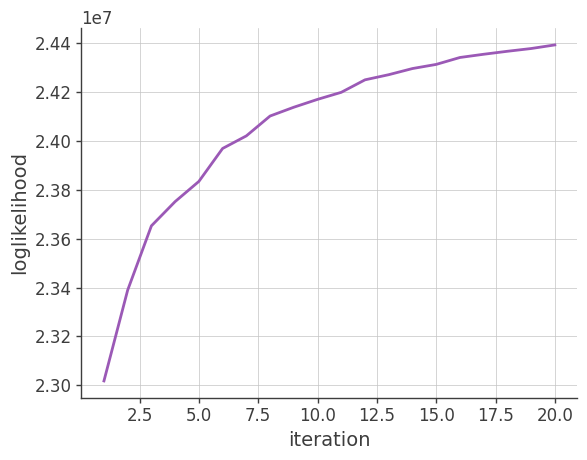

In [41]:
x, y = [], []

for result in all_results:
    x.append(result['iteration'])
    y.append(result['loglikelihood'])
    
plt.plot(x, y)
plt.grid()
plt.xlabel("iteration")
plt.ylabel("loglikelihood")

## Alpha (the factor used for the acceleration)

Plotting $\alpha$ vs the number of iterations. $\alpha$ is a parameter to accelerate the EM algorithm (see the beginning of Section 4). If it is too large, reconstructed images may have artifacts.

Text(0, 0.5, 'alpha')

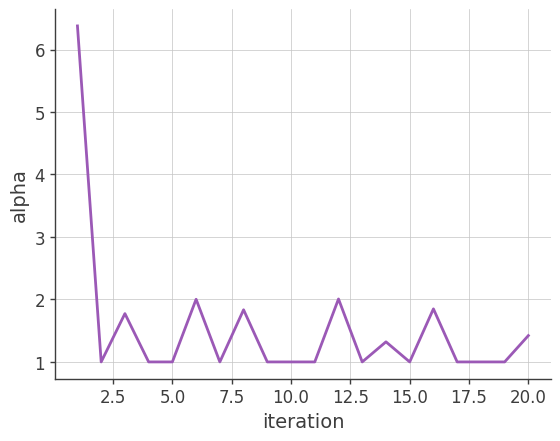

In [42]:
x, y = [], []

for result in all_results:
    x.append(result['iteration'])
    y.append(result['alpha'])
    
plt.plot(x, y)
plt.grid()
plt.xlabel("iteration")
plt.ylabel("alpha")

## Background normalization

Plotting the background nomalization factor vs the number of iterations. If the backgroud model is accurate and the image is reconstructed perfectly, this factor should be close to 1.

Text(0, 0.5, 'background_normalization')

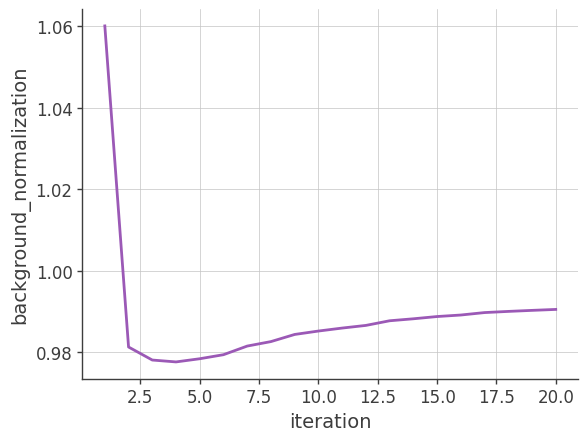

In [43]:
x, y = [], []

for result in all_results:
    x.append(result['iteration'])
    y.append(result['background_normalization'])
    
plt.plot(x, y)
plt.grid()
plt.xlabel("iteration")
plt.ylabel("background_normalization")

## The reconstructed images

In [44]:
def plot_reconstructed_image(result, source_position = None): # source_position should be (l,b) in degrees
    iteration = result['iteration']
    image = result['model_map']

    for energy_index in range(image.axes['Ei'].nbins):
        map_healpxmap = HealpixMap(data = image[:,energy_index], unit = image.unit)

        _, ax = map_healpxmap.plot('mollview')        
        
        _.colorbar.set_label(str(image.unit))
        
        if source_position is not None:
            ax.scatter(source_position[0]*u.deg, source_position[1]*u.deg, transform=ax.get_transform('world'), color = 'red')

        plt.title(label = f"iteration = {iteration}, energy_index = {energy_index} ({image.axes['Ei'].bounds[energy_index][0]}-{image.axes['Ei'].bounds[energy_index][1]})")

Plotting the reconstructed images in all of the energy bands at the 20th iteration

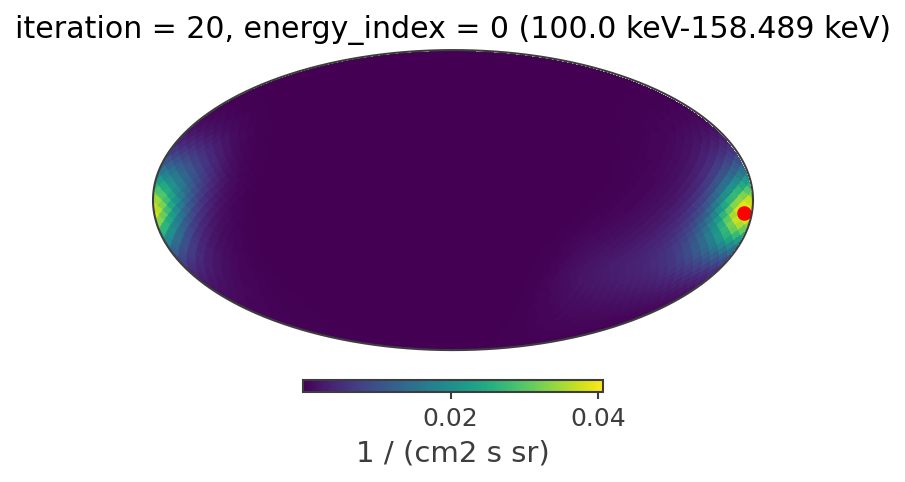

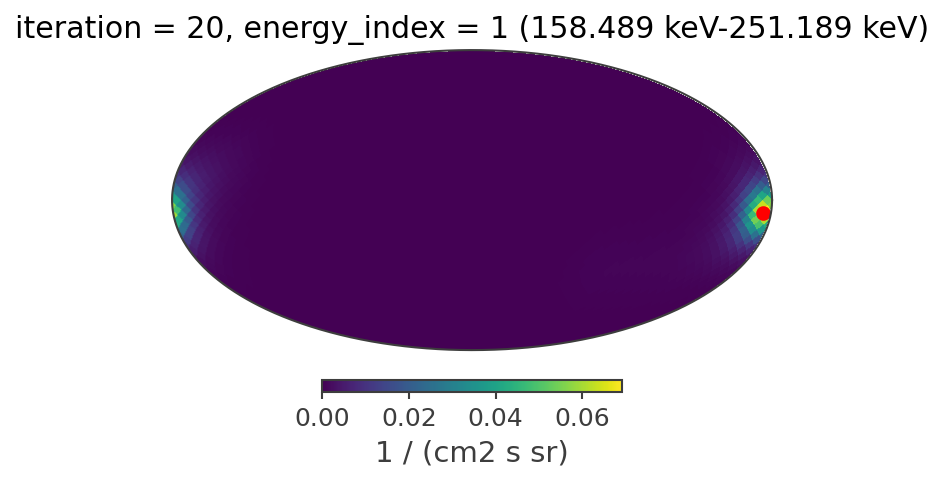

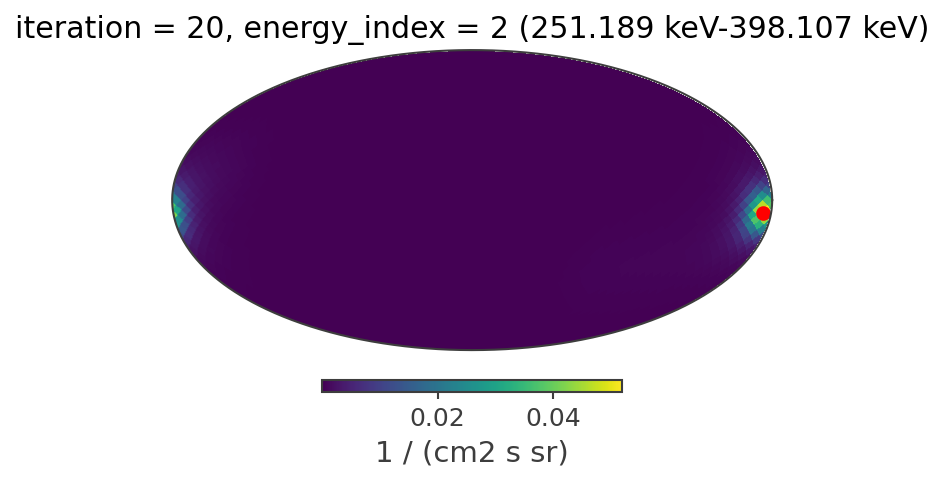

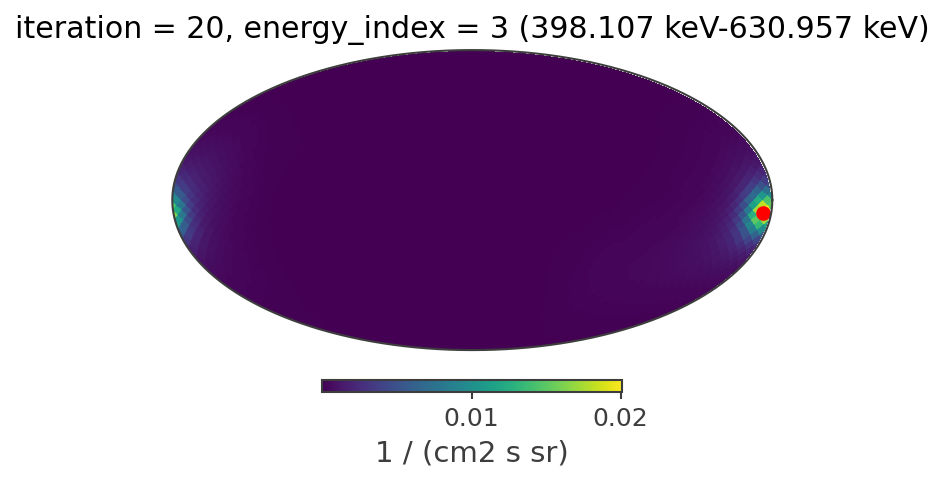

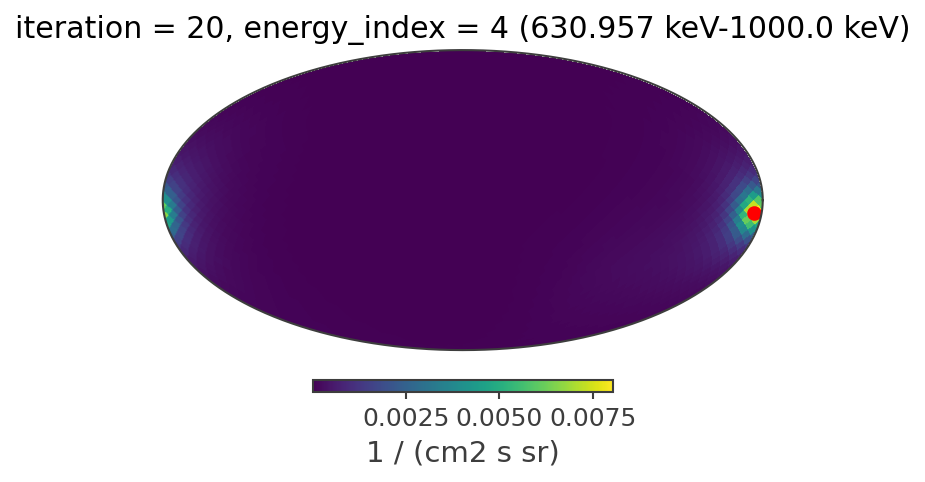

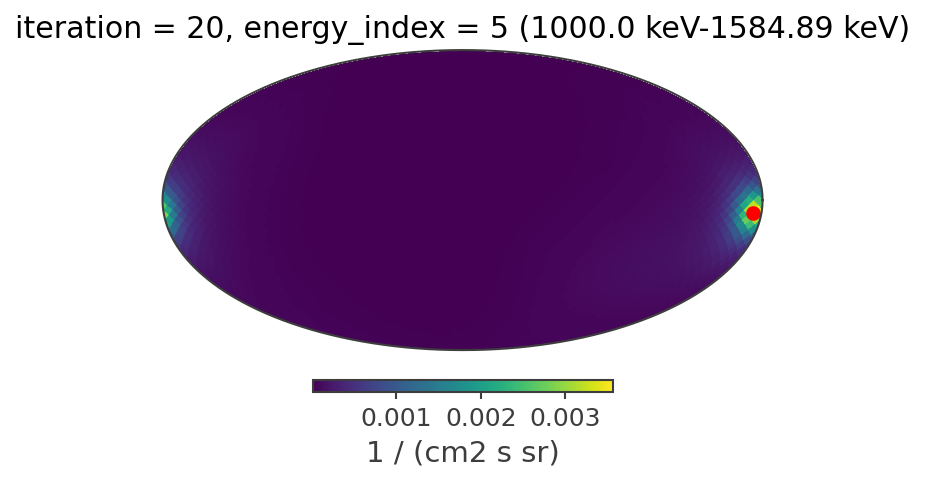

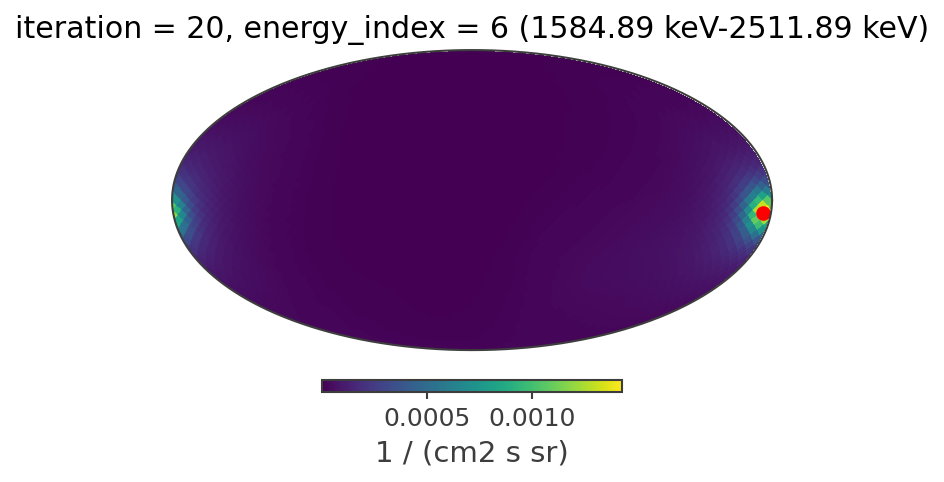

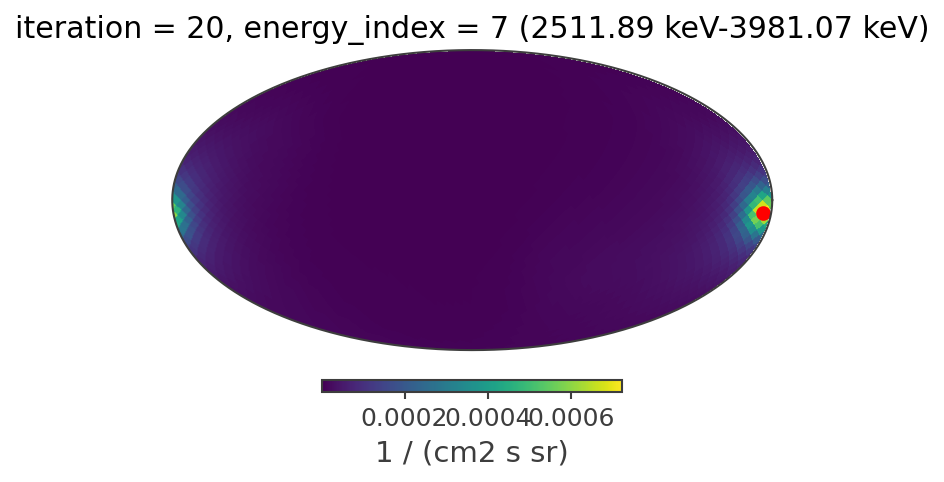

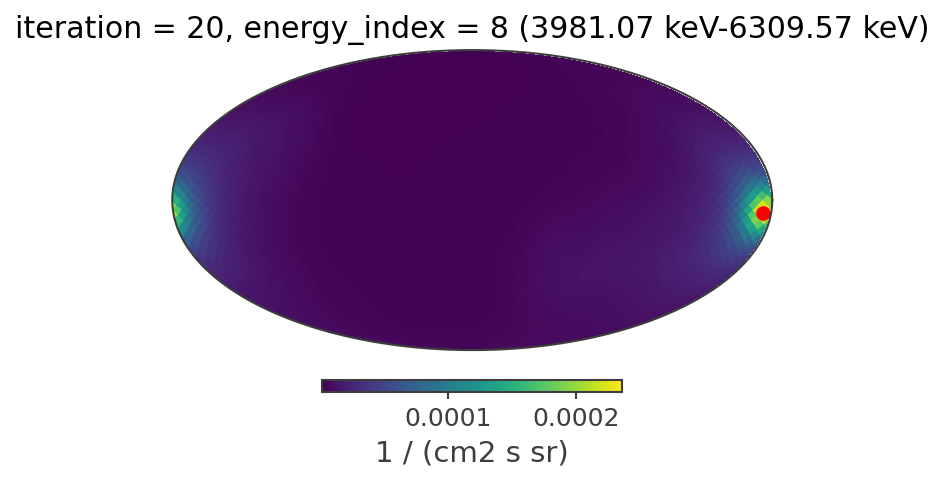

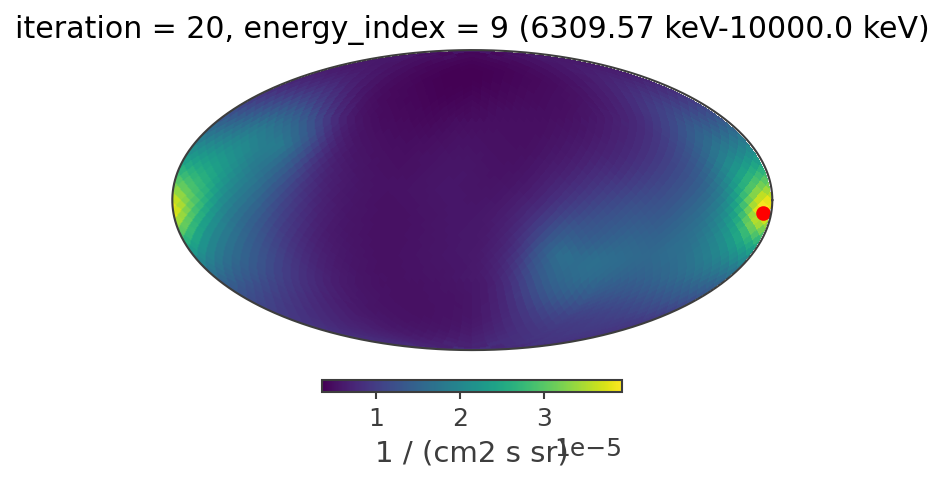

In [47]:
iteration = 19

plot_reconstructed_image(all_results[iteration], source_position = (source_position['l'] * u.deg, source_position['b'] * u.deg))

## Spectrum

Plotting the gamma-ray spectrum at 20th interation. The photon flux at each energy band shown here is calculated as the accumulation of the flux values in all pixel at each energy band.

In [48]:
energy_truth = []
flux_truth = []

with open("crab_spec.dat", "r") as f:
    for line in f:
        data = line.split('\t')
        if data[0] == 'DP':
            energy_truth.append(float(data[1]))# * u.keV)
            flux_truth.append(float(data[2]))# / u.cm**2 / u.s / u.keV)

In [49]:
def get_differential_flux(model_map):
    pixelarea = 4 * np.pi / model_map.axes['lb'].npix * u.sr
        
    differential_flux = np.sum(model_map, axis = 0) * pixelarea / model_map.axes['Ei'].widths
    
    return differential_flux

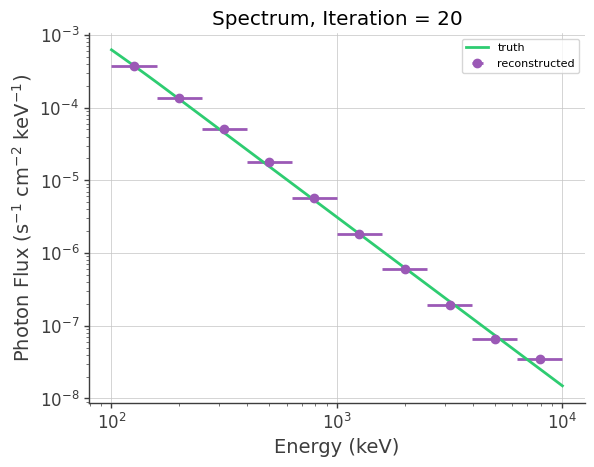

In [50]:
iteration = 19

result = all_results[iteration]

model_map = result['model_map']

differential_flux = get_differential_flux(model_map)

energy_band = model_map.axes['Ei'].centers

err_energy = model_map.axes['Ei'].bounds.T - model_map.axes['Ei'].centers
err_energy[0,:] *= -1
        
plt.errorbar(energy_band, differential_flux, xerr=err_energy, fmt='o', label = 'reconstructed')
plt.plot(energy_truth, flux_truth, label = 'truth')
plt.xscale("log")
plt.yscale("log")

plt.xlabel("Energy (keV)")
plt.ylabel(r"Photon Flux (s$^{-1}$ cm$^{-2}$ keV$^{-1}$)")
plt.title(f"Spectrum, Iteration = {result['iteration']}")
plt.grid()
plt.legend()

## Plot All

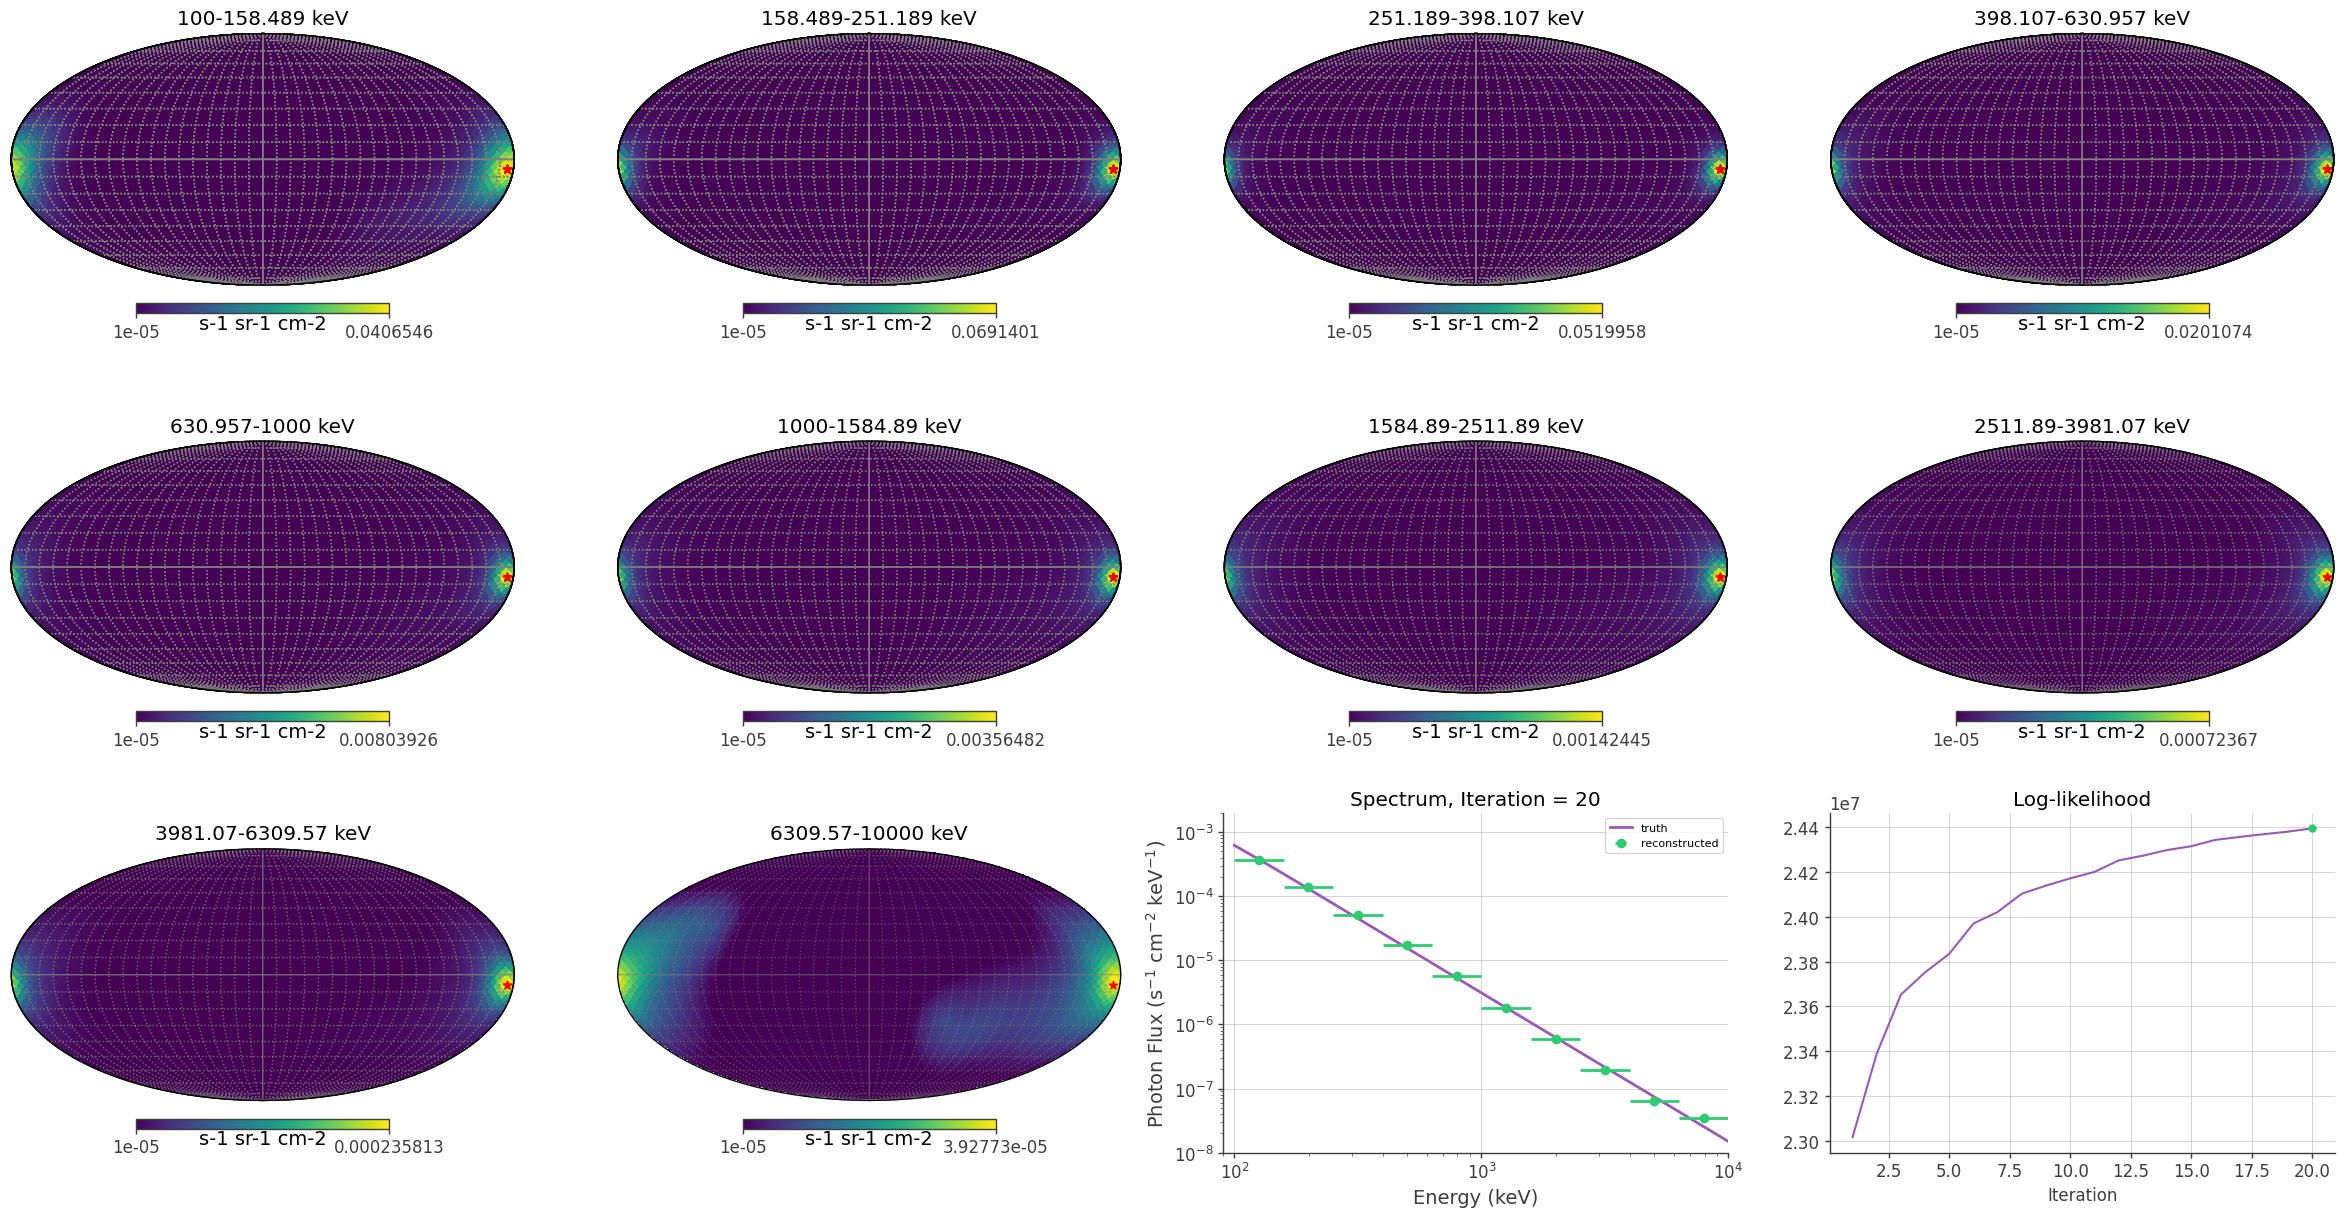

In [53]:
title = ["100-158.489 keV",
"158.489-251.189 keV", 
"251.189-398.107 keV", 
"398.107-630.957 keV", 
"630.957-1000 keV", 
"1000-1584.89 keV", 
"1584.89-2511.89 keV", 
"2511.89-3981.07 keV", 
"3981.07-6309.57 keV", 
"6309.57-10000 keV"]

position = {"l":184.600, "b": -5.800}

i_iteration = 19 # ==>20th iteration
th = -5

fig = plt.figure(figsize=(30, 15))
gs = GridSpec(nrows=3, ncols=4)

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])
ax3 = fig.add_subplot(gs[0, 3])
ax4 = fig.add_subplot(gs[1, 0])
ax5 = fig.add_subplot(gs[1, 1])
ax6 = fig.add_subplot(gs[1, 2])
ax7 = fig.add_subplot(gs[1, 3])
ax8 = fig.add_subplot(gs[2, 0])
ax9 = fig.add_subplot(gs[2, 1])

axes = [ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]
    
ax_spectrum = fig.add_subplot(gs[2, 2])
ax_likelihood = fig.add_subplot(gs[2, 3])
#ax_background = fig.add_subplot(gs[1, 3])

#plt.subplots_adjust(wspace=0.4, hspace=0.5)

image = all_results[i_iteration]['model_map']

for i_energy in range(image.axes['Ei'].nbins):   
    plt.axes(axes[i_energy])

    data = image.contents[:,i_energy]
    data[data < 10**th * image.unit] = 10**th * image.unit

    hp.mollview(data, norm = 'liner', min = 10**th, title = title[i_energy], hold=True, unit = "s-1 sr-1 cm-2")
    hp.graticule(color='gray', dpar = 10, alpha = 0.5)
    hp.projscatter(theta = position["l"], phi = position["b"], lonlat = True, color = 'red', linewidths = 1, marker = "*")

###        
        
plt.axes(ax_spectrum)

energy_band = image.axes['Ei'].centers

err_energy = image.axes['Ei'].bounds.T - image.axes['Ei'].centers
err_energy[0,:] *= -1

differential_flux = get_differential_flux(image)
    
plt.plot(energy_truth, flux_truth, label = 'truth')

plt.errorbar(energy_band, differential_flux, xerr=err_energy, fmt='o', label = 'reconstructed')
plt.xscale("log")
plt.yscale("log")
plt.xlim(90, 10000)
plt.ylim(1e-8, 2e-3)
    
plt.xlabel("Energy (keV)")
plt.ylabel(r"Photon Flux (s$^{-1}$ cm$^{-2}$ keV$^{-1}$)")
plt.title(f"Spectrum, Iteration = {iteration+1}")
plt.grid()
plt.legend()
        
###        
        
plt.axes(ax_likelihood)

iterations = [_['iteration'] for _ in all_results]
loglikelihoods = [_['loglikelihood'] for _ in all_results]

plt.plot(iterations, loglikelihoods, linewidth = 1.5)
plt.plot([iterations[i_iteration]], [loglikelihoods[i_iteration]], markersize = 10, marker = ".")

plt.xlabel("Iteration", fontsize = 12)
plt.title("Log-likelihood")
plt.grid()

###
#    plt.axes(ax_background)

#    plt.plot(iterations, background_normalizations, linewidth = 1.5)
#    plt.plot([iterations[i]], [background_normalizations[i]], markersize = 10, marker = ".")

#    plt.xlabel("Iteration", fontsize = 12)
    #plt.ylabel("Background Normalization", fontsize = 12)
#    plt.ylim(0.7, 1.4)
#    plt.title("Background Normalization")
#    plt.grid()    

#    plt.savefig(f"fig_{i:03}.png")